
# Introduction #

Project on Flower Classification with Convolutional Neural Network for COMP 8610 – Project 2.

# Importing Required Libraries 

In [ ]:
import math, re, os
import numpy as np
import tensorflow as tf
import warnings 
warnings.filterwarnings("ignore")

print("Tensorflow version " + tf.__version__)

# Setting Distribution Strategy for TPU


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)


# Loading the Data




In [ ]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) 

In [ ]:

IMAGE_SIZE = [512, 512]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

#processing the images into floats from 0,1 and reshaping to the size required for a TPU.
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) 
    return image

#reading the labels for my images and returns a dataset with the image and label in a pair.
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),  
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label 

#reading the unlabeled data to use for testing.
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "id": tf.io.FixedLenFeature([], tf.string),  

    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum 

#Reading multiple files at once to improve performance. 
#Ordering data order decreases the speed and as the data will be shuffled later on anyways. 
def load_dataset(filenames, labeled=True, ordered=False):

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disabling order

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

## Create Data Pipelines ##

Splitting into train test data

In [ ]:

def data_augment(image, label):
    #data augmentation to prevent overfitting and to find more patterns.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat(10)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # get next batch while training 
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))


In [ ]:
BATCH_SIZE = 16 

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

In [ ]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

In [ ]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) 

# Data Exploration


In [ ]:
from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: 
        numpy_labels = [None for _ in enumerate(numpy_images)]
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """

    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        

    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    

    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)

    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: 
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
ds_iter = iter(ds_train.unbatch().batch(20))

The below code block can be reran to get a new batch of data.

In [ ]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

# Defining Baseline Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Dense, Dropout

EPOCHS = 20

 
# model0 = tf.keras.Sequential()
# model0.add(Dense(1024, activation='relu', input_shape=(512,512,3)))
# BatchNormalization(axis=1, momentum=0.06),
# model0.add(Dropout(0.01)),
# model0.add(Dense(2048, activation='relu'))
# BatchNormalization(axis=1, momentum=0.06),
# model0.add(Dropout(0.01)),
# model0.add(Dense(2048, activation='relu'))
# BatchNormalization(axis=1, momentum=0.06),
# model0.add(Dropout(0.01)),
# model0.add(Dense(1024, activation='relu'))
# BatchNormalization(axis=1, momentum=0.06),
# model0.add(Dropout(0.01)),
# model0.add(Dense(len(CLASSES), activation='softmax'))
    
# modelZero = tf.keras.Sequential([
#     tf.keras.layers.Dense(1024, activation = "relu"),
#     tf.keras.layers.BatchNormalization(),  
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(2048, activation = "relu"),
#     tf.keras.layers.BatchNormalization(),  
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(2048, activation = "relu"),
#     tf.keras.layers.BatchNormalization(),  
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(1024, activation = "relu"),
#     tf.keras.layers.BatchNormalization(),  
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(len(CLASSES), activation='softmax')
# ])

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten
gu_seed=tf.keras.initializers.GlorotUniform(seed=1)

EPOCHS = 20
with strategy.scope():
    """pretrained_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential(([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ]))"""
    model0 = tf.keras.Sequential()
    model0.add(Conv2D(32, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu', input_shape=(512,512,3)))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu'))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu'))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Flatten())
    model0.add(Dense(len(CLASSES), activation='softmax'))
    
    
    """
    model2 = tf.keras.Sequential()
    model2.add(Conv2D(32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(512,512,1)))
    model2.add(MaxPool2D(pool_size=(3,3)))
    model2.add(Dropout(0.25))
    
    model2.add(Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'))
    model2.add(MaxPool2D(pool_size=(3,3)))
    model2.add(Dropout(0.25))
    
    model2.add(Flatten())
    model2.add(Dense(len(CLASSES), activation='softmax'))"""

In [ ]:
model0.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model0.summary()

In [ ]:
# Define training epochs
EPOCHS = 20
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model0.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

## Model Baseline Graphs


In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

## Model Baseline Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model0.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

# Defining first model - Transfer learning
 ResNet50



**Ignoring model due to poor accuracy**

In [ ]:
EPOCHS = 20
with strategy.scope():
    pretrained_model = tf.keras.applications.resnet50.ResNet50(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
        
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [ ]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

## Training #

## Defining Learning Rate Schedule ##

Using a learning rate schedule that slows down to have a better chance at reaching global mimimum

In [ ]:
def adapt_learning_rate(epoch,
                   start_lr = 0.0005, min_lr = 0.00005, max_lr = 0.0001,
                   rampup_epochs = 8, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [adapt_learning_rate(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Fit Model ##

Training the model over 20 Epochs

In [ ]:
# Define training epochs
EPOCHS = 20
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

## Evaluation Model 1


In [ ]:
!pip install scikit-learn

In [ ]:

from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

# Defining second model - Transfer Learning
ResNet50 model 

**Ignoring model due to poor accuracy**

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten
gu_seed=tf.keras.initializers.GlorotUniform(seed=1)

EPOCHS = 20
with strategy.scope():
    """pretrained_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential(([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ]))"""
    model0 = tf.keras.Sequential()
    model0.add(Conv2D(32, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu', input_shape=(512,512,3)))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu'))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu'))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Flatten())
    model0.add(Dense(len(CLASSES), activation='softmax'))
    
    
    """
    model2 = tf.keras.Sequential()
    model2.add(Conv2D(32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(512,512,1)))
    model2.add(MaxPool2D(pool_size=(3,3)))
    model2.add(Dropout(0.25))
    
    model2.add(Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'))
    model2.add(MaxPool2D(pool_size=(3,3)))
    model2.add(Dropout(0.25))
    
    model2.add(Flatten())
    model2.add(Dense(len(CLASSES), activation='softmax'))"""


EPOCHS = 20
with strategy.scope():
    pretrained_model = tf.keras.applications.resnet50.ResNet50(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
        
    )
    pretrained_model.trainable = True
    
    modelTwo = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5), 
        
    model0.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu'))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu'))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Flatten())        
        
        
        
        
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])    
    

In [ ]:
modelTwo.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

modelTwo.summary()

In [ ]:
def adapt_learning_rate(epoch,
                   start_lr = 0.0005, min_lr = 0.00005, max_lr = 0.0001,
                   rampup_epochs = 8, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [adapt_learning_rate(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
# Define training epochs
EPOCHS = 20
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = modelTwo.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

One interesting thing to notice is that even though the training accuracy increases significantly from the start, the model is rather slow to adapt to the patterns and learn to generalise to the validation data. This could be due to it taking much longer to change the weights of the ResNet50 model as the model itself should have set weights already.

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = modelTwo.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

The graphs above with a heavy fluctuation of model validation loss at the start indicates that my initial learning rate may be too high. However as both curves eventually start to move to each other, it is concluded that the network's traning graph is likely to have one big global minima (second image) rather than many local minima (first image). This means that the learning rate shouldn't have too much of an effect on the network and the network's performace is near maximised at 91% accuracy.
<div>
     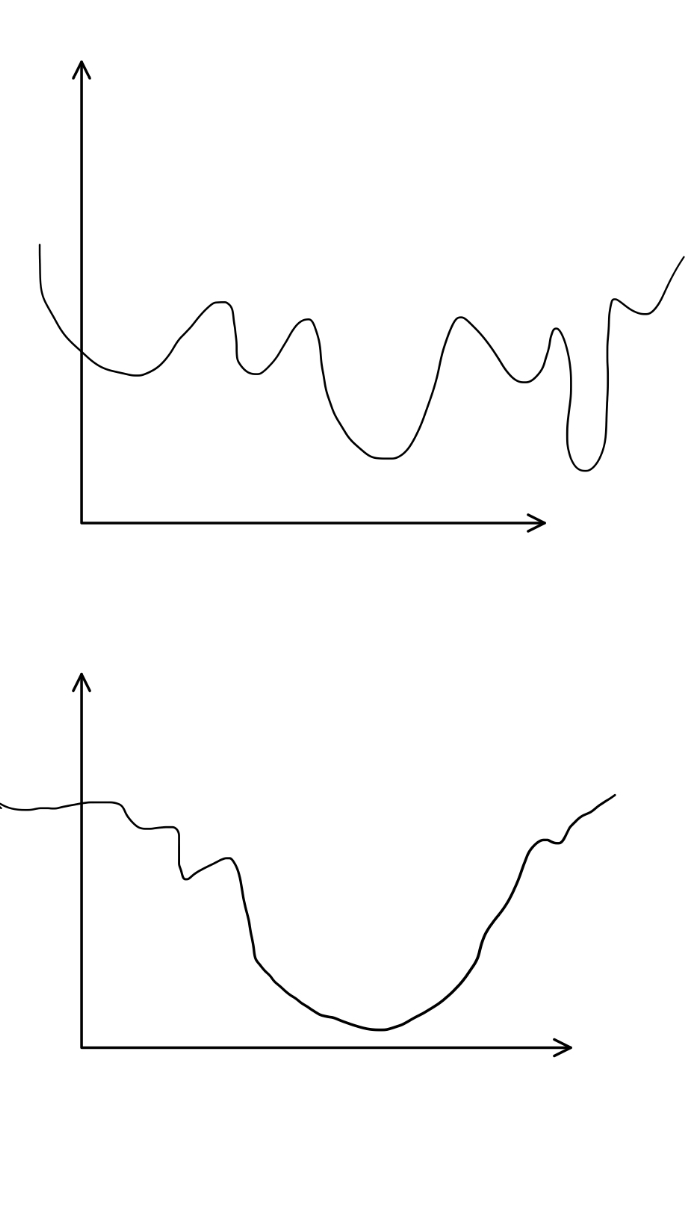
</div>

# Defining Third model - Transfer Learning
Xception model. 

**Ignoring model due to poor accuracy**

In [ ]:
EPOCHS = 20
with strategy.scope():
    pretrained_model = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
        
    )
    pretrained_model.trainable = False
    
    modelThree = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1024, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(2048, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4096, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation = "relu"),
        tf.keras.layers.BatchNormalization(), 
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1024, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(512, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [ ]:
modelThree.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

modelThree.summary()

In [ ]:
def adapt_learning_rate(epoch,
                   start_lr = 0.0005, min_lr = 0.00005, max_lr = 0.0001,
                   rampup_epochs = 6, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [adapt_learning_rate(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
# Define training epochs
EPOCHS = 20
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = modelThree.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:

from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = modelThree.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

## Evaluate Predictions #


In [ ]:
EPOCHS = 20
with strategy.scope():
    pretrained_model = tf.keras.applications.resnet50.ResNet50(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
        
    )
    pretrained_model.trainable = True
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [ ]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

In [ ]:
def adapt_learning_rate(epoch,
                   start_lr = 0.0005, min_lr = 0.00005, max_lr = 0.0001,
                   rampup_epochs = 8, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [adapt_learning_rate(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
# Define training epochs
EPOCHS = 20
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = modelThree.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

## Model Trainng and Validation Loss and Accuracy Curves ##

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
#move up??


import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## Confusion Matrix ##



In [ ]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

In [ ]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

## Visual Validation ##


In [ ]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

In [ ]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

# New Code

# Transfer Learning New Model 1 - ResNet50

In [ ]:
EPOCHS = 50
from tensorflow.keras.models import Model


with strategy.scope():
    pretrained_model = tf.keras.applications.resnet50.ResNet50(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3],
        pooling='avg',
    )
    pretrained_model.trainable = True
    
    x = pretrained_model.output
    predictions = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(x)
    modelOne = tf.keras.models.Model(inputs=pretrained_model.input, outputs=predictions)

In [ ]:
modelOne.compile(
    optimizer='nadam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

modelOne.summary()

In [ ]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
# Define training epochs
EPOCHS = 20
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = modelOne.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilitiesOne = modelOne.predict(images_ds)
cm_predictionsOne = np.argmax(cm_probabilitiesOne, axis=-1)

labels = range(len(CLASSES))
cmatOne = confusion_matrix(
    cm_correct_labels,
    cm_predictionsOne,
    labels=labels,
)
cmatOne = (cmatOne.T / cmatOne.sum(axis=1)).T # normalize

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

scoreOne = f1_score(
    cm_correct_labels,
    cm_predictionsOne,
    labels=labels,
    average='macro',
)
precisionOne = precision_score(
    cm_correct_labels,
    cm_predictionsOne,
    labels=labels,
    average='macro',
)
recallOne = recall_score(
    cm_correct_labels,
    cm_predictionsOne,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmatOne, scoreOne, precisionOne, recallOne)

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictionsOne,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Model One - Transfer Learning - ResNet50")
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

# Transfer Learning New Model 2 -  DenseNet201 

In [ ]:
EPOCHS = 50
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201


with strategy.scope():
    pretrained_model = tf.keras.applications.DenseNet201(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3],
        pooling='avg',
    )
    pretrained_model.trainable = True
    
    x = pretrained_model.output
    predictions = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(x)
    modelTwoNew = tf.keras.models.Model(inputs=pretrained_model.input, outputs=predictions)

In [ ]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
modelTwoNew.compile(
    optimizer='nadam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

modelTwoNew.summary()

In [ ]:
# Define training epochs
EPOCHS = 25
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = modelTwoNew.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilitiesTwo = modelTwoNew.predict(images_ds)
cm_predictionsTwo = np.argmax(cm_probabilitiesTwo, axis=-1)

labels = range(len(CLASSES))
cmatTwo = confusion_matrix(
    cm_correct_labels,
    cm_predictionsTwo,
    labels=labels,
)
cmatTwo = (cmatTwo.T / cmatTwo.sum(axis=1)).T # normalize

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

scoreTwo = f1_score(
    cm_correct_labels,
    cm_predictionsTwo,
    labels=labels,
    average='macro',
)
precisionTwo = precision_score(
    cm_correct_labels,
    cm_predictionsTwo,
    labels=labels,
    average='macro',
)
recallTwo = recall_score(
    cm_correct_labels,
    cm_predictionsTwo,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmatTwo, scoreTwo, precisionTwo, recallTwo)

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictionsTwo,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Model Two - Transfer Learning - DenseNet201")
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

# Transfer Learning New Model 3 -  Xception

In [ ]:
with strategy.scope():
    pretrained_model_xception_seven = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3],
                                               include_top=False,
                                               weights='imagenet')
    
    model_xception_seven = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model_xception_seven,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [ ]:
model_xception_seven.summary()

In [ ]:
with strategy.scope():
    
    model_xception_seven.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['sparse_categorical_accuracy'])

In [ ]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
STEPS_PER_EPOCH = 20

history = model_xception_seven.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback, tf.keras.callbacks.ModelCheckpoint(filepath='Xception.h5', monitor='val_loss',
                                            save_best_only=True)],
    workers=3
)

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilitiesSeven = model_xception_seven.predict(images_ds)
cm_predictionsSeven = np.argmax(cm_probabilitiesSeven, axis=-1)

labels = range(len(CLASSES))
cmatSeven = confusion_matrix(
    cm_correct_labels,
    cm_predictionsSeven,
    labels=labels,
)
cmatSeven = (cmatSeven.T / cmatSeven.sum(axis=1)).T # normalize

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

scoreSeven = f1_score(
    cm_correct_labels,
    cm_predictionsSeven,
    labels=labels,
    average='macro',
)
precisionSeven = precision_score(
    cm_correct_labels,
    cm_predictionsSeven,
    labels=labels,
    average='macro',
)
recallSeven = recall_score(
    cm_correct_labels,
    cm_predictionsSeven,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmatSeven, scoreSeven, precisionSeven, recallSeven)

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictionsSeven,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Model Three - Transfer Learning - Xception")
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

------------------------------

# Data Augmentation

# Data Augmentation Model 1

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

SIZE = 512

GCS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
GCS_PATH_EXT = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')
IMAGE_PATH = GCS_PATH + '/tfrecords-jpeg-{size}x{size}'.format(size=SIZE)

IMAGENET_FILES = tf.io.gfile.glob(GCS_PATH_EXT + '/imagenet_no_test/tfrecords-jpeg-{size}x{size}/*.tfrec'.format(size=SIZE))
INATURELIST_FILES = tf.io.gfile.glob(GCS_PATH_EXT + '/inaturalist_no_test/tfrecords-jpeg-{size}x{size}/*.tfrec'.format(size=SIZE))
OPENIMAGE_FILES = tf.io.gfile.glob(GCS_PATH_EXT + '/openimage_no_test/tfrecords-jpeg-{size}x{size}/*.tfrec'.format(size=SIZE))
OXFORD_FILES = tf.io.gfile.glob(GCS_PATH_EXT + '/oxford_102_no_test/tfrecords-jpeg-{size}x{size}/*.tfrec'.format(size=SIZE))
TENSORFLOW_FILES = tf.io.gfile.glob(GCS_PATH_EXT + '/tf_flowers_no_test/tfrecords-jpeg-{size}x{size}/*.tfrec'.format(size=SIZE))

TRAINING_FILENAMES = tf.io.gfile.glob(IMAGE_PATH + '/train/*.tfrec') + IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES + OXFORD_FILES + TENSORFLOW_FILES

VALIDATION_FILENAMES = tf.io.gfile.glob(IMAGE_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(IMAGE_PATH + '/test/*.tfrec') 

IMAGE_SIZE = [SIZE, SIZE]

BATCH_SIZE = 128
EPOCHS = 35

In [ ]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'] 

In [ ]:
!pip install tensorflow-addons


In [ ]:
import tensorflow_addons as tfa

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    dataset = dataset.with_options(ignore_order)
    
    if labeled:
        dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTOTUNE)
    else:
        dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=AUTOTUNE)
    
    return dataset


In [ ]:
def random_cut_out(image, label):
    image = tf.expand_dims(image, axis=0)
    return tf.squeeze(tfa.image.random_cutout(image, (192, 192), constant_values = 1), axis=0), label

def data_augment(image, label):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    image = tf.image.resize(image, [SIZE+30, SIZE+30], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, size=[SIZE, SIZE, 3])
    
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) 
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) 
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1)
        
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    return image, label  

def data_augment_method_three(image, label):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    image = tf.image.resize(image, [SIZE+30, SIZE+30], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, size=[SIZE, SIZE, 3])
    
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) 
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) 
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    return image, label  

def data_augment_method_two(x,y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x,y

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(random_cut_out, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_training_dataset_aug_two():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment_method_two, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(random_cut_out, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_training_dataset_aug_three():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment_method_three, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(random_cut_out, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))


In [ ]:
ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

# Data Augmentation Model 2

In [ ]:
from tensorflow.keras.models import Model




with strategy.scope():
    pretrained_model = tf.keras.applications.resnet50.ResNet50(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3],
        pooling='avg',
    )
    pretrained_model.trainable = True
    
    x = pretrained_model.output
    predictions = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(x)
    modelThreeNew = tf.keras.models.Model(inputs=pretrained_model.input, outputs=predictions)

In [ ]:
modelThreeNew.compile(
    optimizer='nadam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

 

modelThreeNew.summary()

 USE THIS

In [ ]:
with strategy.scope():
    pretrained_model_xception = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3],
                                               include_top=False,
                                               weights='imagenet')
    
    model_xception = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model_xception,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [ ]:
model_xception.summary()

In [ ]:
with strategy.scope():
    
    model_xception.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['sparse_categorical_accuracy'])

------

In [ ]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
STEPS_PER_EPOCH = 20

history = model_xception.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback, tf.keras.callbacks.ModelCheckpoint(filepath='Xception.h5', monitor='val_loss',
                                            save_best_only=True)],
    workers=3
)

Ignore

In [ ]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

 

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

 

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

 

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

ignore

In [ ]:
EPOCHS = 20
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

 

history = modelThreeNew.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilitiesThree = model_xception.predict(images_ds)
cm_predictionsThree = np.argmax(cm_probabilitiesThree, axis=-1)

labels = range(len(CLASSES))
cmatThree = confusion_matrix(
    cm_correct_labels,
    cm_predictionsThree,
    labels=labels,
)
cmatThree = (cmatThree.T / cmatThree.sum(axis=1)).T # normalize

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

scoreThree = f1_score(
    cm_correct_labels,
    cm_predictionsThree,
    labels=labels,
    average='macro',
)
precisionThree = precision_score(
    cm_correct_labels,
    cm_predictionsThree,
    labels=labels,
    average='macro',
)
recallThree = recall_score(
    cm_correct_labels,
    cm_predictionsThree,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmatThree, scoreThree, precisionThree, recallThree)

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictionsThree,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Model Five - Data Augmentation - Combination of Both")
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

# Explaore Augmentation Dataset

In [ ]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image * 0.5 + 0.5)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [ ]:
ds_iter = iter(ds_train.unbatch().batch(20))

In [ ]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

# Data Augmentation model 3

In [ ]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment_method_two, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(random_cut_out, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


In [ ]:
ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

In [ ]:
with strategy.scope():
    pretrained_model_xception_two = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3],
                                               include_top=False,
                                               weights='imagenet')
    
    model_xception_two = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model_xception_two,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [ ]:
model_xception_two.summary()

In [ ]:
with strategy.scope():
    
    model_xception_two.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['sparse_categorical_accuracy'])

In [ ]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## 20 epoches

In [ ]:
STEPS_PER_EPOCH = 20

history = model_xception_two.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback, tf.keras.callbacks.ModelCheckpoint(filepath='Xception.h5', monitor='val_loss',
                                            save_best_only=True)],
    workers=3
)

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilitiesSix = model_xception_two.predict(images_ds)
cm_predictionsSix = np.argmax(cm_probabilitiesSix, axis=-1)

labels = range(len(CLASSES))
cmatSix = confusion_matrix(
    cm_correct_labels,
    cm_predictionsSix,
    labels=labels,
)
cmatSix = (cmatSix.T / cmatSix.sum(axis=1)).T # normalize

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

scoreSix = f1_score(
    cm_correct_labels,
    cm_predictionsSix,
    labels=labels,
    average='macro',
)
precisionSix = precision_score(
    cm_correct_labels,
    cm_predictionsSix,
    labels=labels,
    average='macro',
)
recallSix = recall_score(
    cm_correct_labels,
    cm_predictionsSix,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmatSix, scoreSix, precisionSix, recallSix)

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictionsSix,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Model Six - Data Augmentation - Flip Only")
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

## 35 epoches

In [ ]:
STEPS_PER_EPOCH = 35

history = model_xception_two.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback, tf.keras.callbacks.ModelCheckpoint(filepath='Xception.h5', monitor='val_loss',
                                            save_best_only=True)],
    workers=3
)

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilitiesSix35 = model_xception_two.predict(images_ds)
cm_predictionsSix35 = np.argmax(cm_probabilitiesSix35, axis=-1)

labels = range(len(CLASSES))
cmatSix = confusion_matrix(
    cm_correct_labels,
    cm_predictionsSix35,
    labels=labels,
)
cmatSix = (cmatSix.T / cmatSix.sum(axis=1)).T # normalize

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

scoreSix = f1_score(
    cm_correct_labels,
    cm_predictionsSix35,
    labels=labels,
    average='macro',
)
precisionSix = precision_score(
    cm_correct_labels,
    cm_predictionsSix35,
    labels=labels,
    average='macro',
)
recallSix = recall_score(
    cm_correct_labels,
    cm_predictionsSix35,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmatSix, scoreSix, precisionSix, recallSix)

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictionsSix35,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Model Six - Data Augmentation - Flip Only - 35 Epoches")
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

# NEW

# Data Augmentation model 4

In [ ]:

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment_method_three, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(random_cut_out, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()


In [ ]:
with strategy.scope():
    pretrained_model_xception_three = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3],
                                               include_top=False,
                                               weights='imagenet')
    
    model_xception_three = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model_xception_three,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [ ]:
model_xception_three.summary()

In [ ]:
with strategy.scope():
    
    model_xception_three.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['sparse_categorical_accuracy'])

In [ ]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
STEPS_PER_EPOCH = 20

history = model_xception_three.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback, tf.keras.callbacks.ModelCheckpoint(filepath='Xception.h5', monitor='val_loss',
                                            save_best_only=True)],
    workers=3
)

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilitiesFour = model_xception_three.predict(images_ds)
cm_predictionsFour = np.argmax(cm_probabilitiesFour, axis=-1)

labels = range(len(CLASSES))
cmatFour = confusion_matrix(
    cm_correct_labels,
    cm_predictionsFour,
    labels=labels,
)
cmatFour = (cmatFour.T / cmatFour.sum(axis=1)).T # normalize

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

scoreFour = f1_score(
    cm_correct_labels,
    cm_predictionsFour,
    labels=labels,
    average='macro',
)
precisionFour = precision_score(
    cm_correct_labels,
    cm_predictionsFour,
    labels=labels,
    average='macro',
)
recallFour = recall_score(
    cm_correct_labels,
    cm_predictionsFour,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmatFour, scoreFour, precisionFour, recallFour)

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictionsFour,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Model Four - Data Augmentation - White Squares only")
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161321) to chat with other Learners.*